In [1]:
import numpy as np
from cmeutils.sampling import is_equilibrated, equil_sample
import unyt as u
from unyt import Unit
import signac
import gsd.hoomd
import matplotlib.pyplot as plt

Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.

****** PyMBAR will use 64-bit JAX! *******
* JAX is currently set to 32-bit bitsize *
* which is its default.                  *
*                                        *
* PyMBAR requires 64-bit mode and WILL   *
* enable JAX's 64-bit mode when called.  *
*                                        *
* This MAY cause problems with other     *
* Uses of JAX in the same code.          *
******************************************



In [4]:
project = signac.get_project("../validation/")
job_filter = {"remove_hydrogens": True, "remove_charges": True}

In [3]:
for job in project.find_jobs(filter=job_filter):
    data = np.genfromtxt(job.fn("log.txt"), names=True)
    vol = data["mdcomputeThermodynamicQuantitiesvolume"]
    pe = data["mdcomputeThermodynamicQuantitiespotential_energy"]
    sample_idx = len(vol)//2
    vol_eq = is_equilibrated(vol[sample_idx:], threshold_fraction=0.10, threshold_neff=100)[0]
    pe_eq = is_equilibrated(pe[sample_idx:], threshold_fraction=0.10, threshold_neff=100)[0]
    print(vol_eq, pe_eq)
    print()

True True

True True

True True

True True

True True

True True

True True

True True

True True

True True

True True

True True

True True

True True

True True

True True



In [5]:
for job in project.find_jobs(filter=job_filter):
    data = np.genfromtxt(job.fn("log.txt"), names=True)
    vol = data["mdcomputeThermodynamicQuantitiesvolume"]
    sample_idx = len(vol)//2
    uncorr_sample, uncorr_indices, prod_start, Neff = equil_sample(
        vol[sample_idx:], threshold_fraction=0.10, threshold_neff=100
    )
    vol_nm = uncorr_sample * (job.doc.ref_length**3) * Unit(f"{job.doc.ref_length_units}**3")
    vol_cm = vol_nm.to("cm**3")
    job.doc.avg_vol = np.mean(vol_cm.value)
    job.doc.vol_std = np.std(vol_cm.value)
    #np.savetxt(job.fn("vol_sample_indices.txt"), uncorr_indices + sample_idx)
    np.savetxt(job.fn("vol_cc.txt"), vol_cm.value)
    with gsd.hoomd.open(job.fn("restart.gsd")) as traj:
        snap = traj[0]
        reduced_mass = sum(snap.particles.mass)
        mass_amu = reduced_mass * job.doc.ref_mass * Unit(job.doc.ref_mass_units)
        mass_g = mass_amu.to("g")
        job.doc.mass_g = mass_g.value
    job.doc.avg_density = job.doc.mass_g / job.doc.avg_vol
    job.doc.density_std = job.doc.mass_g / job.doc.vol_std
    job.doc.volume_sampled = True

/home/chrisjones4/miniconda3/envs/hoomd-organics/lib/python3.9/site-packages/synced_collections/numpy_utils.py:46: NumpyConversionWarning: Any numpy types provided will be transparently converted to the closest base Python equivalents.
  warnings.warn(NUMPY_CONVERSION_WARNING, NumpyConversionWarning)
/home/chrisjones4/miniconda3/envs/hoomd-organics/lib/python3.9/site-packages/synced_collections/numpy_utils.py:43: NumpyConversionWarning: Any numpy types provided will be transparently converted to the closest base Python equivalents.
  warnings.warn(NUMPY_CONVERSION_WARNING, NumpyConversionWarning)


In [10]:
job.doc.vol_std

4.960713412999566e-22

1.1 /home/erjank_project/chrisjones/1-PPS-MSIBI/pps-msibi/validation/workspace/5170fc82172eeb7caa9e1900d4be88e6
1.2 /home/erjank_project/chrisjones/1-PPS-MSIBI/pps-msibi/validation/workspace/c1c14879ae8691c7e9860b96b6ce0ba4
1.3 /home/erjank_project/chrisjones/1-PPS-MSIBI/pps-msibi/validation/workspace/1485e6544370a63aa8111dc42aca915d
1.4 /home/erjank_project/chrisjones/1-PPS-MSIBI/pps-msibi/validation/workspace/97a747037f4a57d9e56fdde8b68e7297
1.5 /home/erjank_project/chrisjones/1-PPS-MSIBI/pps-msibi/validation/workspace/003dc9a8475d8454871ca1d44db9bd8f
1.6 /home/erjank_project/chrisjones/1-PPS-MSIBI/pps-msibi/validation/workspace/1d4201a5f219953f2e0b0076371395be
1.7 /home/erjank_project/chrisjones/1-PPS-MSIBI/pps-msibi/validation/workspace/d4f3b7cf4f85a7d5f7e42c4894504fff
1.8 /home/erjank_project/chrisjones/1-PPS-MSIBI/pps-msibi/validation/workspace/c6d9867f5c636f0ae79635dea7565f20
1.9 /home/erjank_project/chrisjones/1-PPS-MSIBI/pps-msibi/validation/workspace/1363430a2a2caf49d52fa72b4

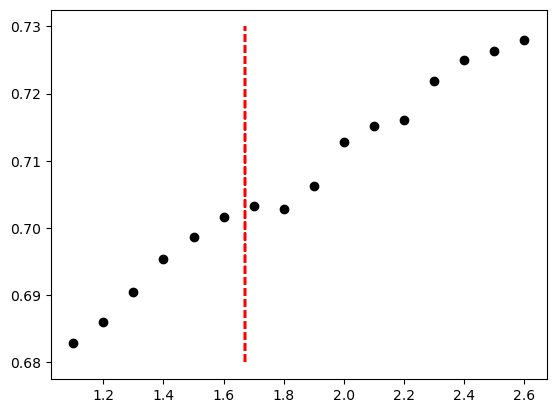

In [29]:
for kT, job in project.find_jobs(filter=job_filter).groupby("kT"):
    job = list(job)[0]
    print(kT, job.path)
    plt.plot(kT, 1/job.doc.avg_density, "ko")
    plt.vlines(x=1.67, ymin=0.68, ymax=0.73, ls="--", color="red")

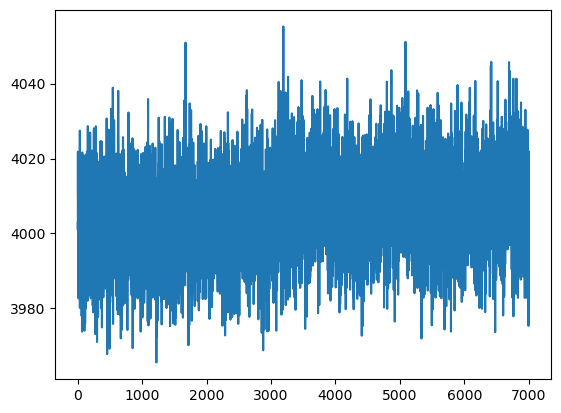

In [23]:
plt.plot(data["mdcomputeThermodynamicQuantitiesvolume"][-7000:])